# exp021

In [1]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [2]:
exp_name = 'exp021'
memo = '学習時down_sampling n200 negをdist順に'

In [3]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
if MODE == "kaggle_inference":
    from cuml import ForestInference
    import treelite
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_MODEL = "distilbert-base-uncased"
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_MODEL = "../input/distilbertbaseuncased"

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 200
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 512
NW = 2
SVD_N_COMP = 50

In [6]:
class Cat2VecModel(nn.Module):
    def __init__(self):
        super(Cat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_MODEL)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def inference(ds):
    cat2vec_model = Cat2VecModel()
    cat2vec_model = cat2vec_model.cuda()
    
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(loader):
            v = cat2vec_model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [7]:
def make_bert_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")

    cat_ds = InferenceDataset(cat_df, max_len=MAX_LEN, col=col)
    V = inference(cat_ds)
    svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return bert_vec

In [8]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    return df

In [9]:
def extract_candidate(df, is_train=False):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)

        if is_train:
            id2poi = get_id2poi(country_df)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                    metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        country_df = country_df.explode(['match_id','d_near'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        
        if is_train:
            country_df["target"] = (country_df["point_of_interest"] == country_df["match_id"].map(id2poi)).astype(int)
            match_count = country_df["target"].sum()
            country_df_pos = country_df[country_df["target"]==1].copy()
            country_df_pos = country_df_pos.drop(columns=["target"])
            country_df_neg = country_df[country_df["target"]==0].copy()
            if len(country_df_neg) > match_count:
                country_df_neg = country_df_neg.sort_values("d_near").head(match_count)
            country_df_neg = country_df_neg.drop(columns=["target"])
            dfs.append(country_df_pos)
            dfs.append(country_df_neg)
        else:
            dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [10]:
def add_orgin_data(df, org_df):
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [11]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [12]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [13]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []

        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_gesh"] = df[f"match_{c}_gesh"].astype(np.float16)
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_leven"] = df[f"match_{c}_leven"].astype(np.float16)
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_jaro"] = df[f"match_{c}_jaro"].astype(np.float16)
        df[f"match_{c}_lcs"] = lcss
        df[f"match_{c}_lcs"] = df[f"match_{c}_lcs"].astype(np.float16)
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"{c}_len"] = df[f"{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[[f"match_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"match_{c}_nleven"] = df[f"match_{c}_nleven"].astype(np.float16)
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_lcs"] / df[f"{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_nlcsi"].astype(np.float16)
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_nlcs0"].astype(np.float16)
            df.drop(f'{c}_len',axis=1, inplace = True)
            df.drop(f"match_{c}_len",axis=1, inplace = True)

    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [14]:
def add_vec_sim_features(df, vec, vec_name, col):
    sim_list = []
    for str1, str2 in tqdm(df[[f"{col}", f"match_{col}"]].values.astype(str)):
        if str1==str1 and str2==str2:
            sim = cosine_similarity(vec[str1].reshape(1, -1), vec[str2].reshape(1, -1))[0][0]
        else:
            sim = -1
        sim_list.append(sim)
    df[f"{vec_name}_sim_{col}"] = sim_list
    df[f"{vec_name}_sim_{col}"] = df[f"{vec_name}_sim_{col}"].astype(np.float16)
    return df

In [15]:
def reduce_data_size(df, features):
    if MODE == 'local_train':
        df = df[features + ['target', 'id', 'match_id']].copy()
    elif MODE == 'kaggle_inference':
        df = df[features + ['id', 'match_id']].copy()


    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
        
    return df

In [16]:
def train_model(df, features):
    params = {'objective': 'binary', 
              'boosting': 'gbdt',
              'learning_rate': 0.1, 
              'metric': 'binary_logloss', 
              'seed': SEED, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.5745709668124809, 
              'lambda_l2': 0.5123383865042099, 
              'num_leaves': 239, 
              'feature_fraction': 0.784, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 5
              }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [17]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        model.save_model("test.lgb")
        fi = ForestInference()
        fi = ForestInference.load("test.lgb", output_class=True, model_type="lightgbm")
        pred += fi.predict(df[features]) / N_SPLITS
    return pred

In [18]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [19]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [20]:
def run_train():
    train_origin = pd.read_csv(INPUT_DIR + "train.csv")
    train_origin = preprocess(train_origin)

    # trainデータの分割
    kf = GroupKFold(n_splits=2)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
        train_origin.loc[val_idx, "set"] = i

    # 1st stage
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], is_train=True), 
        extract_candidate(train_origin[train_origin["set"]==1], is_train=True), 
    ])
    train = add_orgin_data(train, train_origin)
    stage1_max_score = calc_max_score(train, train_origin)

    # 2nd stage
    # create target
    train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
    train["target"] = train["target"].fillna(0)

    train = add_distance_features(train)
    
    # reduce memory
    train = train.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                                'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                                'match_zip', 'match_country', 'match_url', 'match_phone'])
    gc.collect()

    # bert類似度
    bert_vec_categories = make_bert_vec(train_origin[["categories"]], "categories")
    train = add_vec_sim_features(train, bert_vec_categories, "bert", "categories")
    del bert_vec_categories
    gc.collect()

    print("add_bert_sim_name")
    bert_vec_name = make_bert_vec(train_origin[["name"]], "name")
    train = add_vec_sim_features(train, bert_vec_name, "bert", "name")
    del bert_vec_name
    gc.collect()


    not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                    'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                    'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                    'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                    'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                    'match_url_leven', 'state', 'match_phone', 'match_country']
    features = [c for c in train.columns if c not in not_use_cols]
    with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
        pickle.dump(features, f)

    train = reduce_data_size(train, features)

    oof, stage2_mean_accuracy = train_model(train, features)
    oof = transform_data(oof, train_origin)

    cv_score = get_score(oof, train_origin)
    print(f'cv_score = ' + '{:.5f}'.format(cv_score))

    oof = postprocess(oof)
    cv_score_after_pp = get_score(oof, train_origin)
    print(f'cv_score(after_pp) = ' + '{:.5f}'.format(cv_score_after_pp))


    report = f'{exp_name}\n'
    report += memo + '\n'
    report += 'stage1_max_score : ' + '{:.5f}'.format(stage1_max_score) + '\n'
    report += 'stage2_mean_accuracy : ' + '{:.5f}'.format(stage2_mean_accuracy) + '\n'
    report += 'cv_score : ' + '{:.5f}'.format(cv_score) + '\n'
    report += 'cv_score_after_pp : ' + '{:.5f}'.format(cv_score_after_pp) + '\n'
    print(report)
    line_notify.send(report)
    slack_notify.send(report)

In [21]:
def run_inference():
    test_origin = pd.read_csv(INPUT_DIR + "test.csv")
    sub = pd.read_csv(INPUT_DIR + "sample_submission.csv", usecols=["id"])

    if len(test_origin) == 5:
        test_origin = pd.read_csv(INPUT_DIR + "train.csv")
        kf = GroupKFold(n_splits=100)
        for i, (trn_idx, val_idx) in enumerate(kf.split(test_origin, test_origin['point_of_interest'], test_origin['point_of_interest'])):
            test_origin = test_origin.loc[val_idx]
            test_origin = test_origin.reset_index(drop=True)
            sub = test_origin[["id"]].copy()
            break
    
    test_origin = preprocess(test_origin)
    
    kf = GroupKFold(n_splits=5)
    for i, (trn_idx, val_idx) in enumerate(kf.split(test_origin, test_origin['country'].fillna(""), test_origin['country'].fillna(""))):
        test_origin.loc[val_idx, "c_fold"] = int(i)

    country_tests = []
    for c_fold in test_origin["c_fold"].unique():
        test_origin_batch = test_origin[test_origin["c_fold"]==c_fold].copy()
        test_origin_batch = test_origin_batch.reset_index(drop=True)
        test_origin_batch =test_origin_batch.drop(columns=["c_fold"])

        # 1st stage
        test = extract_candidate(test_origin_batch)

        # 2nd stage
        print("add_org")
        test = add_orgin_data(test, test_origin_batch)

        print("add_dist_feat")
        test = add_distance_features(test)

        # reduce memory
        test = test.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                                    'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                                    'match_zip', 'match_country', 'match_url', 'match_phone'])
        gc.collect()


        # bert類似度
        bert_vec_categories = make_bert_vec(test_origin_batch[["categories"]], "categories")
        test = add_vec_sim_features(test, bert_vec_categories, "bert", "categories")
        del bert_vec_categories
        gc.collect()
        bert_vec_name = make_bert_vec(test_origin_batch[["name"]], "name")
        test = add_vec_sim_features(test, bert_vec_name, "bert", "name")
        del bert_vec_name
        gc.collect()
        
        with open(MODEL_DIR + 'features.pickle', 'rb') as f:
            features = pickle.load(f)
        test = reduce_data_size(test, features)

        print('test_dataset_info')
        print(test.info())

        test['prob'] = model_inference(test, features)
        test = transform_data(test, test_origin_batch)
        country_tests.append(test)

        del test, test_origin_batch
        gc.collect()

    test = pd.concat(country_tests)
    test = postprocess(test)

    sub = sub.merge(test, on="id", how="left") 
    sub.to_csv('submission.csv', index=False)

100%|██████████| 211/211 [05:45<00:00,  1.64s/it]


1st_stage_max_score : 0.96126


208it [06:54,  1.99s/it]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2366142/2366142 [05:03<00:00, 7791.79it/s]


add_bert_sim_name


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2366142/2366142 [04:58<00:00, 7929.67it/s]


fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 947019, number of negative: 945894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8315
[LightGBM] [Info] Number of data points in the train set: 1892913, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500297 -> initscore=0.001189
[LightGBM] [Info] Start training from score 0.001189
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0616235	valid_1's binary_logloss: 0.098707
[2000]	training's binary_logloss: 0.0328129	valid_1's binary_logloss: 0.0810109
[3000]	training's binary_logloss: 0.0182055	valid_1's binary_logloss: 0.0705985
[4000]	training's binary_logloss: 0.0107802	valid_1's binary_logloss: 0.0644178
[5000]	training's binary_logloss: 0.00697566	valid_1's binary_logloss: 0.0611463
[6000]	training's binary_logloss: 0.004

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 946067, number of negative: 946846
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8461
[LightGBM] [Info] Number of data points in the train set: 1892913, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499794 -> initscore=-0.000823
[LightGBM] [Info] Start training from score -0.000823
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0619367	valid_1's binary_logloss: 0.0988865
[2000]	training's binary_logloss: 0.0329354	valid_1's binary_logloss: 0.0814207
[3000]	training's binary_logloss: 0.0181292	valid_1's binary_logloss: 0.0709424
[4000]	training's binary_logloss: 0.0107848	valid_1's binary_logloss: 0.0651948
[5000]	training's binary_logloss: 0.00698459	valid_1'

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 946786, number of negative: 946128
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8465
[LightGBM] [Info] Number of data points in the train set: 1892914, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500174 -> initscore=0.000695
[LightGBM] [Info] Start training from score 0.000695
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0618436	valid_1's binary_logloss: 0.0975143
[2000]	training's binary_logloss: 0.0328243	valid_1's binary_logloss: 0.0795973
[3000]	training's binary_logloss: 0.018056	valid_1's binary_logloss: 0.0689952
[4000]	training's binary_logloss: 0.0107924	valid_1's binary_logloss: 0.0632656
[5000]	training's binary_logloss: 0.0069687	valid_1's binary_logloss: 0.0599937
[6000]	training's binary_logloss: 0.0048

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 946010, number of negative: 946904
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8378
[LightGBM] [Info] Number of data points in the train set: 1892914, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499764 -> initscore=-0.000945
[LightGBM] [Info] Start training from score -0.000945
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0617496	valid_1's binary_logloss: 0.0973412
[2000]	training's binary_logloss: 0.0330497	valid_1's binary_logloss: 0.0799998
[3000]	training's binary_logloss: 0.0183872	valid_1's binary_logloss: 0.0695444
[4000]	training's binary_logloss: 0.0109711	valid_1's binary_logloss: 0.0634634
[5000]	training's binary_logloss: 0.00706404	valid_1's binary_logloss: 0.0600211
[6000]	training's binary_logloss: 0.

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 946510, number of negative: 946404
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8406
[LightGBM] [Info] Number of data points in the train set: 1892914, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500028 -> initscore=0.000112
[LightGBM] [Info] Start training from score 0.000112
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0615618	valid_1's binary_logloss: 0.0981143
[2000]	training's binary_logloss: 0.0329765	valid_1's binary_logloss: 0.0808341
[3000]	training's binary_logloss: 0.0183825	valid_1's binary_logloss: 0.0705831
[4000]	training's binary_logloss: 0.0109252	valid_1's binary_logloss: 0.0647406
[5000]	training's binary_logloss: 0.00705341	valid_1's binary_logloss: 0.0614084
[6000]	training's binary_logloss: 0.00

100%|██████████| 1138812/1138812 [00:01<00:00, 750141.38it/s]


cv_score(after_pp) = 0.95228
exp021
学習時down_sampling n200 negをdist順に
stage1_max_score : 0.96126
stage2_mean_accuracy : 0.98048
cv_score : 0.94893
cv_score_after_pp : 0.95228



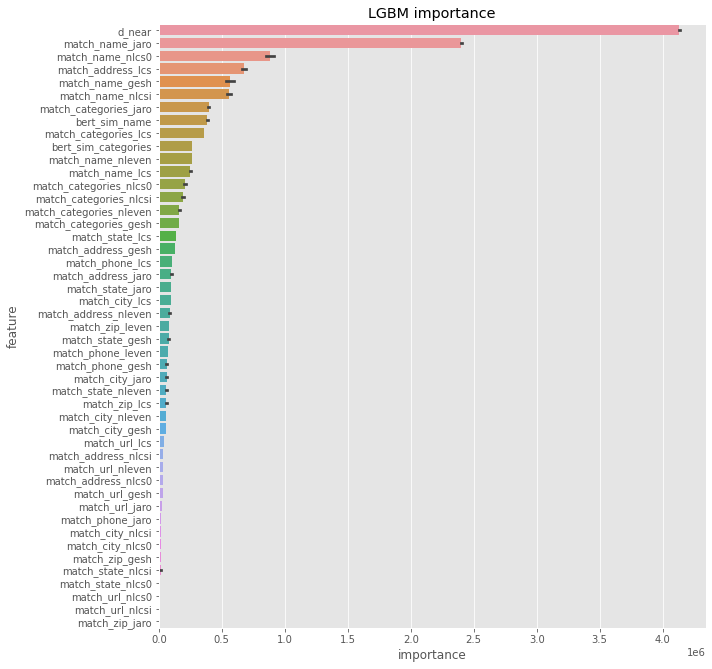

In [22]:
if MODE == 'local_train':
    run_train()
elif MODE == 'kaggle_inference':
    run_inference()